<a href="https://colab.research.google.com/github/LinarKulinar/HPC_SSAU/blob/master/Lab2_Bilateral_filtering/Bilateral_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Высокопроизводительные вычисления.**

**Лабораторная 2. Bilateral filter на CPU и GPU.**

Самарский Университет

В данном блокноте реализован алгоритм bilateral фильтрации изображения на языке python для CPU и для GPU.

Для алгоритма на GPU используется библиотека PyCuda.

Данный код запущен в среде Google Colaboratory:

In [1]:
# установка pycuda
! pip install pycuda

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 4.3 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626633 sha256=3aa18e79b7ac14e44a3b3a90d0ecf3400142992dba8a6a61f00d2b490175a3ac
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=b7994ac9b93254bdee96f14d8bd093a52ee09e598afc45a70bd5fa45bcb38531
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


In [2]:
# импорт библиотек, необходимых для работы

import numpy as np
np.random.seed(0) 

import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
import time
import cv2

# т.к. колаб не отображет cv2.imshow, то для воспользуемся cv2_imshow
from google.colab.patches import cv2_imshow

In [3]:
# CPU функция
def bilateral_filtering_cpu(im, sigma_r, sigma_d):
    result = np.zeros((im.shape[0], im.shape[1]))
    for i in range(1, im.shape[0] - 1):
        for j in range(1, im.shape[1] - 1):
            c, s = 0, 0
            for k in range(i-1, i+2):
                for l in range(j-1, j+2):
                    g = np.exp(-((k - i) ** 2 + (l - j) ** 2) / sigma_d ** 2)
                    r = np.exp(-(im[k, l] - im[i, j]) ** 2 / sigma_r ** 2)
                    c += g*r 
                    s +=   g*r*im[k, l]
            result[i, j] = s / c
    return result


# GPU функция
mod = SourceModule("""
texture<unsigned int, 2, cudaReadModeElementType> tex;

__global__ void bilateral_filtering_gpu(unsigned int* result, const int M, const int N, const float sigma_d, const float sigma_r)
{   
    const int i = threadIdx.x + blockDim.x * blockIdx.x;
    const int j = threadIdx.y + blockDim.y * blockIdx.y;
    if ((i < M) && (j < N)) {
            float s = 0;
            float c = 0;
            for (int l = i - 1; l <= i + 1; l++){
                for (int k = j - 1; k <= j + 1; k++){
                    float img1 = tex2D(tex, k, l) / 255;
                    float img2 = tex2D(tex, i, j) / 255;
                    float g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
                    float r = exp(-pow((img1 - img2) * 255, 2) / pow(sigma_r, 2));
                    c += g * r;
                    s += g * r * tex2D(tex, k, l);
                }
            }
            result[i * N + j] = s / c;
        }
}
""")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).



In [8]:
# ввод данных

def read_data():
  image_url = 'input.png'
  print('Sigma_r = ')
  sigma_r = input()
  print('Sigma_d = ')
  sigma_d = input()
  return image_url, float(sigma_r), float(sigma_d)

image_url, sigma_r, sigma_d  = read_data()
image = cv2.imread(image_url, cv2.IMREAD_GRAYSCALE)

Sigma_r = 
1000
Sigma_d = 
1000


Исходное изображение:

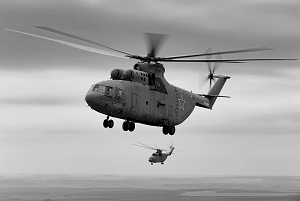

In [9]:
cv2_imshow(image)

In [10]:
N, M = image.shape[0], image.shape[1]

block_size = (8, 8, 1)
grid_size = (int(np.ceil(N/block_size[0])),int(np.ceil(M/block_size[1])))

# Новый раздел

In [11]:
start_cpu = time.time()
result = bilateral_filtering_cpu(image, sigma_r, sigma_d)
cpu_time = time.time() - start_cpu

cv2.imwrite('res_cpu.bmp', result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  # Remove the CWD from sys.path while we load stuff.


True

Результат CPU:

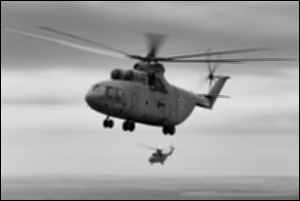

In [12]:
cv2_imshow(result)

In [13]:
result_gpu = np.zeros((N, M), dtype = np.uint32)

bilateral_filtering_gpu = mod.get_function("bilateral_filtering_gpu")

start_gpu = time.time()
tex = mod.get_texref("tex")
tex.set_filter_mode(drv.filter_mode.LINEAR)
tex.set_address_mode(0, drv.address_mode.MIRROR)
tex.set_address_mode(1, drv.address_mode.MIRROR)
drv.matrix_to_texref(image.astype(np.uint32), tex, order="C")
bilateral_filtering_gpu(drv.Out(result_gpu), np.int32(N), np.int32(M), np.float32(sigma_r), np.float32(sigma_d), block=block_size, grid=grid_size, texrefs=[tex])
drv.Context.synchronize()
time_gpu = time.time() - start_gpu

cv2.imwrite('res_gpu.bmp', result_gpu.astype(np.uint8))

True

Результат GPU:

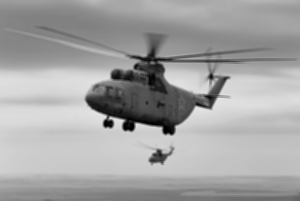

In [14]:
cv2_imshow(result_gpu)

In [15]:
result_gpu.astype(np.uint8)

array([[157, 157, 157, ..., 169, 168, 167],
       [156, 156, 155, ..., 168, 167, 166],
       [154, 153, 153, ..., 166, 165, 164],
       ...,
       [146, 145, 144, ..., 100,  99,  98],
       [144, 143, 142, ...,  99,  98,  96],
       [139, 139, 138, ...,  99,  98,  96]], dtype=uint8)

In [16]:
print('Время CPU: ', cpu_time)
print('Время GPU: ',time_gpu)
print('CPU/GPU:', cpu_time/time_gpu)

Время CPU:  6.495061635971069
Время GPU:  0.004042148590087891
CPU/GPU: 1606.8339624867288
